# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import xlrd
import pickle

from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

### 0.1 Explore Datasets

#### 0.1.1 Explore Azdias Dataset

In [4]:
azdias.shape

(891221, 366)

In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [7]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


#### 0.1.2 Explore Feature Info Dataset

In [8]:
# Load the feature information 
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
del feat_info['Unnamed: 0']
feat_info.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [9]:
feat_info['Attribute'] = feat_info['Attribute'].fillna(method='ffill')
feat_info.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [10]:
# Get the column names which are in azdias dataset but not in feat_info
attr_not_in_feat_info = np.setdiff1d(np.array(azdias.columns), np.array(feat_info.Attribute), assume_unique=True)
print(len(attr_not_in_feat_info))
print(attr_not_in_feat_info)

94
['LNR' 'AKT_DAT_KL' 'ALTER_KIND1' 'ALTER_KIND2' 'ALTER_KIND3' 'ALTER_KIND4'
 'ALTERSKATEGORIE_FEIN' 'ANZ_KINDER' 'ANZ_STATISTISCHE_HAUSHALTE' 'ARBEIT'
 'CAMEO_INTL_2015' 'CJT_KATALOGNUTZER' 'CJT_TYP_1' 'CJT_TYP_2' 'CJT_TYP_3'
 'CJT_TYP_4' 'CJT_TYP_5' 'CJT_TYP_6' 'D19_BANKEN_DIREKT' 'D19_BANKEN_GROSS'
 'D19_BANKEN_LOKAL' 'D19_BANKEN_REST' 'D19_BEKLEIDUNG_GEH'
 'D19_BEKLEIDUNG_REST' 'D19_BILDUNG' 'D19_BIO_OEKO' 'D19_BUCH_CD'
 'D19_DIGIT_SERV' 'D19_DROGERIEARTIKEL' 'D19_ENERGIE' 'D19_FREIZEIT'
 'D19_GARTEN' 'D19_HANDWERK' 'D19_HAUS_DEKO' 'D19_KINDERARTIKEL'
 'D19_KONSUMTYP_MAX' 'D19_KOSMETIK' 'D19_LEBENSMITTEL'
 'D19_LETZTER_KAUF_BRANCHE' 'D19_LOTTO' 'D19_NAHRUNGSERGAENZUNG'
 'D19_RATGEBER' 'D19_REISEN' 'D19_SAMMELARTIKEL' 'D19_SCHUHE'
 'D19_SONSTIGE' 'D19_SOZIALES' 'D19_TECHNIK' 'D19_TELKO_MOBILE'
 'D19_TELKO_ONLINE_QUOTE_12' 'D19_TELKO_REST' 'D19_TIERARTIKEL'
 'D19_VERSAND_REST' 'D19_VERSI_DATUM' 'D19_VERSI_OFFLINE_DATUM'
 'D19_VERSI_ONLINE_DATUM' 'D19_VERSI_ONLINE_QUOTE_12' 'D19_VER

### 0.2 Preprocessing

#### 0.2.1 Assess missing or unkown values for feature info

Find all rows in the feature info dataset for which the value in meaning colunm is either *unknown* or *no classification possible*

In [11]:
feat_info_missing = feat_info[(feat_info["Meaning"].str.contains("unknown") | 
                               feat_info["Meaning"].str.contains("no "))]
feat_info_missing.head(20)


,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
49,BIP_FLAG,NaN,0,no company in the building
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown


Convert the value column to a list

In [12]:
feat_info_missing = feat_info_missing['Value'].groupby([feat_info_missing.Attribute]).apply(list).reset_index()
feat_info_missing.rename(columns={'Value': 'missing_or_unknown'}, inplace=True)
feat_info_missing

,Attribute,missing_or_unknown
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]
5,BIP_FLAG,"[-1, 0]"
6,CAMEO_DEUG_2015,[-1]
7,CAMEO_DEUINTL_2015,[-1]
8,CJT_GESAMTTYP,[0]
9,D19_BANKEN_ANZ_12,[0]


#### 0.2.2 Assess missing or unkown values for azdias dataset

In [13]:
print('Number of naturally missing values: {}'.format(azdias.isnull().sum().sum()))

Number of naturally missing values: 33492923


In [14]:
%%time
# Identify missing or unknown data values and convert them to NaNs.

for idx in feat_info_missing.index:
    column_name = feat_info_missing.iloc[idx]['Attribute']
    print(column_name)
    missing_or_unknown = feat_info_missing.iloc[idx]['missing_or_unknown']
    if column_name in azdias.columns:
        if isinstance(missing_or_unknown[0], str): 
            missing_or_unknown = [int(value) for value in feat_info_missing.iloc[idx]['missing_or_unknown'][0].split(',')]
        azdias[column_name] = azdias[column_name].replace(missing_or_unknown, np.nan)

AGER_TYP
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
BALLRAUM
BIP_FLAG
CAMEO_DEUG_2015
CAMEO_DEUINTL_2015
CJT_GESAMTTYP
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_DIREKT_RZ
D19_BANKEN_GROSS_RZ
D19_BANKEN_LOKAL_RZ
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_BANKEN_REST_RZ
D19_BEKLEIDUNG_GEH_RZ
D19_BEKLEIDUNG_REST_RZ
D19_BILDUNG_RZ
D19_BIO_OEKO_RZ
D19_BUCH_RZ
D19_DIGIT_SERV_RZ
D19_DROGERIEARTIKEL_RZ
D19_ENERGIE_RZ
D19_FREIZEIT_RZ
D19_GARTEN_RZ
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_HANDWERK_RZ
D19_HAUS_DEKO_RZ
D19_KINDERARTIKEL_RZ
D19_KK_KUNDENTYP
D19_KOSMETIK_RZ
D19_LEBENSMITTEL_RZ
D19_LOTTO_RZ
D19_NAHRUNGSERGAENZUNG_RZ
D19_RATGEBER_RZ
D19_REISEN_RZ
D19_SAMMELARTIKEL_RZ
D19_SCHUHE_RZ
D19_SONSTIGE_RZ
D19_TECHNIK_RZ
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_DATUM
D19_TELKO_MOBILE_RZ
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_TELKO_RES

In [15]:
print('Number of missing values after conversion: {}'.format(azdias.isnull().sum().sum()))

Number of missing values after conversion: 54942758


#### 0.2.2.1 Assess Missing Data in Each Column

In [16]:
# Find out number of missing data there is in each column of the dataset.
missing_values_per_column = azdias.isnull().sum()
print(missing_values_per_column)

LNR                                0
AGER_TYP                      685843
AKT_DAT_KL                     73499
ALTER_HH                      310267
ALTER_KIND1                   810163
ALTER_KIND2                   861722
ALTER_KIND3                   885051
ALTER_KIND4                   890016
ALTERSKATEGORIE_FEIN          262947
ANZ_HAUSHALTE_AKTIV            93148
ANZ_HH_TITEL                   97008
ANZ_KINDER                     73499
ANZ_PERSONEN                   73499
ANZ_STATISTISCHE_HAUSHALTE     93148
ANZ_TITEL                      73499
ARBEIT                         97216
BALLRAUM                       93740
CAMEO_DEU_2015                 98979
CAMEO_DEUG_2015                98979
CAMEO_INTL_2015                98979
CJT_GESAMTTYP                   4854
CJT_KATALOGNUTZER               4854
CJT_TYP_1                       4854
CJT_TYP_2                       4854
CJT_TYP_3                       4854
CJT_TYP_4                       4854
CJT_TYP_5                       4854
C

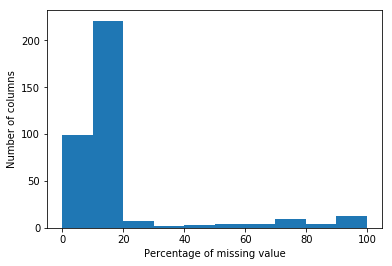

In [17]:
# Investigate pattern in the percentage of missing data in each column
plt.hist(missing_values_per_column/azdias.shape[0] * 100)
plt.xlabel('Percentage of missing value')
plt.ylabel('Number of columns')
plt.show()

From the above histogram we can see that columns with more than 20% of missing values are outliers. Here, we will investigate those columns and drop them. 

In [18]:
# Finding the outlier columns from the dataset.
outlier_column_names = missing_values_per_column[missing_values_per_column/azdias.shape[0] > 0.2].index.tolist()
print(outlier_column_names)
print(len(outlier_column_names))

['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
46


In [19]:
# Drop the outlier columns from the azdias dataframe
azdias.drop(outlier_column_names, axis=1, inplace=True)

In [20]:
# Drop LNR column as it is a unique id assigned to each individual
azdias.drop('LNR', axis=1, inplace=True)

In [21]:
# Shape of azdias dataframe after dropping outlier columns and LNR column
azdias.shape

(891221, 319)

There were 46 columns with greater than 20% of the data missing. These columns were treated as outlier columns and were dropped. Also, the LNR column, which is a unique id assigned to each individual, was dropped.

In [22]:
# Drop the columns from azdias dataset which are not in feat_info
columns_to_drop = set(attr_not_in_feat_info.tolist()) - set(outlier_column_names) - {'LNR'}
azdias.drop(list(columns_to_drop), axis=1, inplace=True)

In [23]:
azdias.shape

(891221, 238)

#### 0.2.2.1 Assess Missing Data in Each Row

In [24]:
# Number of missing values in each row of azdias dataframe
missing_values_per_row = azdias.isnull().sum(axis=1)

In [25]:
missing_values_per_row.value_counts().sort_index()

0      614103
1       32760
2       36149
3       13715
4       12117
5        9871
6        9520
7        3412
8         706
9         289
10       3879
11        111
12        259
13        125
14        133
15         76
16         46
17         15
18          1
23          1
55         56
56        545
57       2790
58       5687
59      11901
60       2695
61       9826
62       4286
63       1007
64        526
        ...  
176       970
177       565
178       705
179       145
180        62
181        39
182        30
183        34
184         9
185        10
186         8
187         5
188         6
189         1
190         3
191       205
192      3439
193     10964
194      3918
195       102
196       138
197       324
198       456
199         6
201     73499
202        21
203        59
204        17
207         1
208         2
Length: 111, dtype: int64

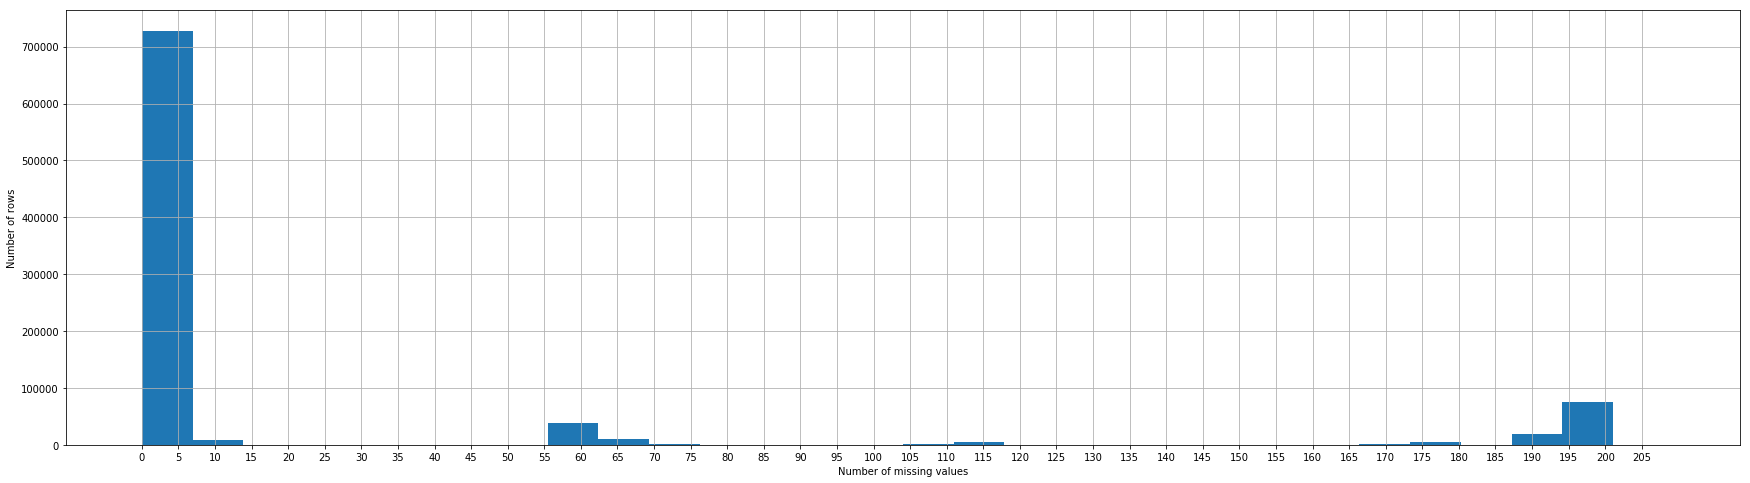

In [26]:
plt.figure(figsize=(30,8))
missing_values_per_row.hist(bins=30)
plt.xlabel('Number of missing values')
plt.ylabel('Number of rows')
plt.xticks(np.arange(0, 210, step=5))
plt.show()

From the above plot we can see that most of the rows have 7 or less missing values. Hence, going forward we will be removing the rows having more than 7 missing values.

In [27]:
# Dividing the azdias dataframe into subsets containing <=7 missing values per row 
# and >7 missing values per row respectively
azdias_missing_values_lte_7 = azdias[missing_values_per_row <= 7]
azdias_missing_values_gt_7 = azdias[missing_values_per_row > 7]

In [28]:
print("Percentage of rows where missing less than or equal to 7 vales are missing: {}".format(
    len(azdias_missing_values_lte_7)/azdias.shape[0]*100))
print("Percentage of rows where missing more than 7 vales are missing: {}".format(
    len(azdias_missing_values_gt_7)/azdias.shape[0]*100))

Percentage of rows where missing less than or equal to 7 vales are missing: 82.09490126466949
Percentage of rows where missing more than 7 vales are missing: 17.90509873533052


In [29]:
few_missing_values_columns = missing_values_per_column[missing_values_per_column <= 3].index.tolist()
dropped_columns = list(set(few_missing_values_columns) - set(azdias.columns))
for col in dropped_columns:
    few_missing_values_columns.remove(col)
# Randomly select five column names
print(len(few_missing_values_columns))
few_missing_values_columns = random.sample(few_missing_values_columns, 5)

26


In [30]:
print(few_missing_values_columns)

['SEMIO_KULT', 'FINANZ_ANLEGER', 'SEMIO_VERT', 'FINANZ_UNAUFFAELLIGER', 'FINANZTYP']


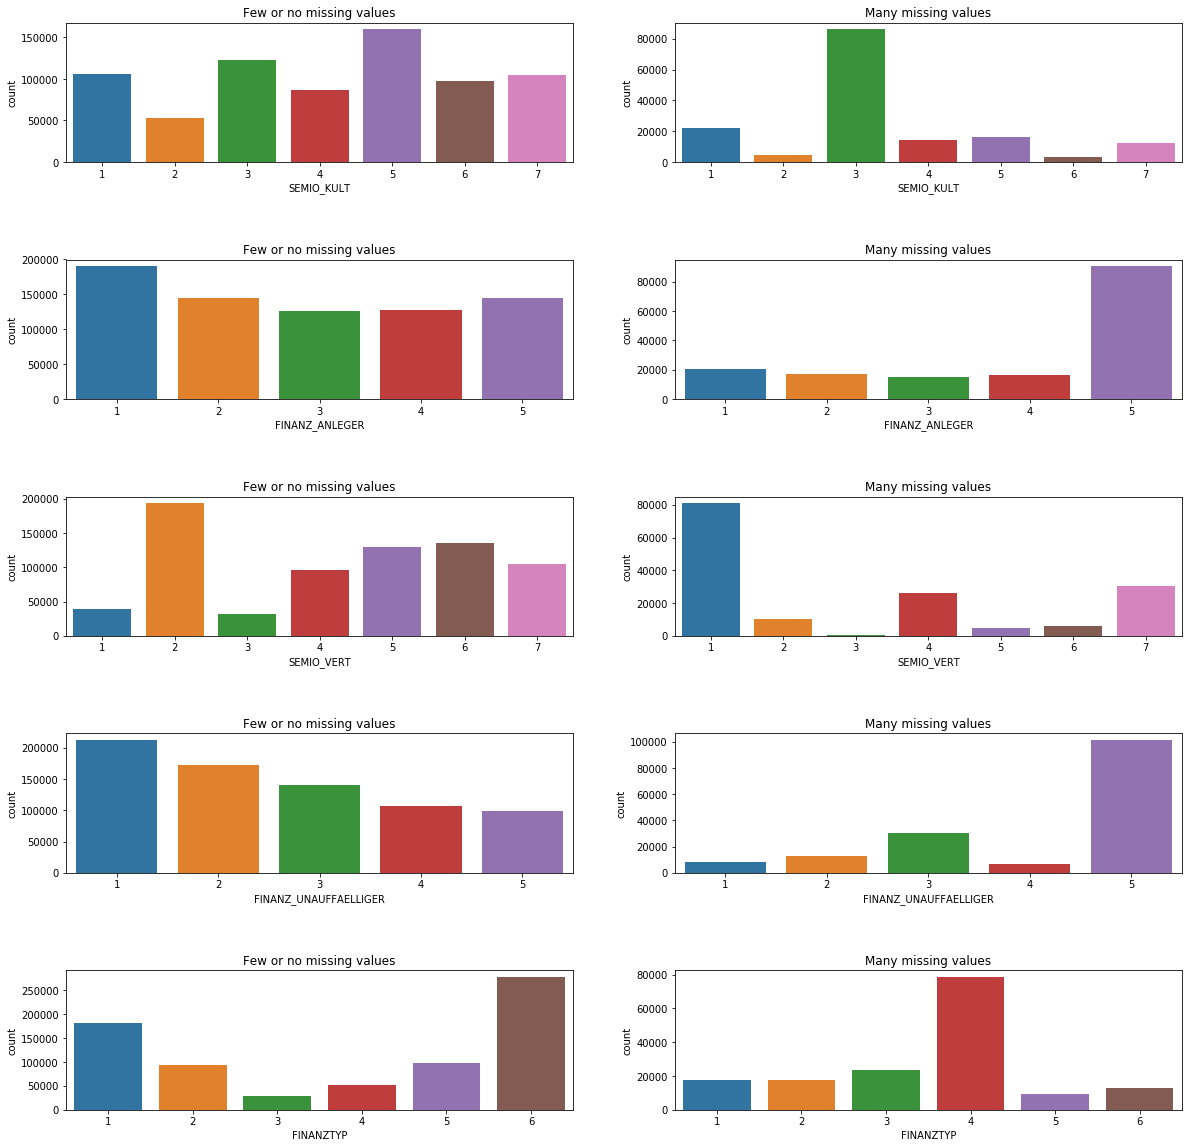

In [31]:
# Comparing the distribution of values for the above five columns between the two subsets.

figure, axs = plt.subplots(nrows=5, ncols=2, figsize = (20,20))
figure.subplots_adjust(hspace=0.7)
for i in range(5):
    sns.countplot(azdias_missing_values_lte_7[few_missing_values_columns[i]], ax=axs[i][0])
    axs[i][0].set_title('Few or no missing values')
    sns.countplot(azdias_missing_values_gt_7[few_missing_values_columns[i]], ax=axs[i][1])
    axs[i][1].set_title('Many missing values')

In [32]:
# Drop rows with >7 missing values in the azdias dataset.
print('Total number of rows in azdias dataset: {}'.format(azdias.shape[0]))

azdias = azdias[azdias.index.isin(azdias_missing_values_lte_7.index)]

print('Number of rows after dropping rows with more than 7 missing values : {}'.format(azdias.shape[0]))

Total number of rows in azdias dataset: 891221
Number of rows after dropping rows with more than 7 missing values : 731647


In [33]:
azdias.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,EWDICHTE,FINANZ_ANLEGER,...,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,11.0,0.0,2.0,0.0,6.0,8A,8,5.0,3.0,5,...,6,1,3.0,2.0,3.0,9.0,4.0,5,2,1
2,10.0,0.0,1.0,0.0,2.0,4C,4,3.0,4.0,2,...,3,4,2.0,1.0,3.0,9.0,2.0,5,2,3
3,1.0,0.0,0.0,0.0,4.0,2A,2,2.0,2.0,2,...,4,4,1.0,1.0,NaN,9.0,7.0,3,2,4
4,3.0,0.0,4.0,0.0,2.0,6B,6,5.0,5.0,1,...,2,7,2.0,2.0,2.0,9.0,3.0,4,1,3
5,5.0,0.0,1.0,0.0,6.0,8C,8,2.0,2.0,2,...,6,2,0.0,2.0,6.0,9.0,7.0,4,2,1


From the above analysis we could see that 82% percentage of the rows had less than or equal to 7 missing values. Remaining 18% of the rows have greater than 7 missing values. 

Next I have compared the distribution of 5 randomly selected columns that have less or equal to 3 values in the two subsets azdias_missing_values_lte_7 and azdias_missing_values_gt_7. We could see from the above plots that the all the randomly selected columns have different distribution in the two subsets. 

Then I have dropped the rows which had greater than 7 missing values. This reduced the number of rows in the dataset from 891221 to 731647.

### 0.2.3 Take a sample of the azdias dataset

In [34]:
# Number of missing values in azdias after removing rows with more than 7 missing values
missing_values_per_row_latest = azdias.isnull().sum(axis=1)

In [35]:
missing_values_per_row_latest.value_counts().sort_index()

0    614103
1     32760
2     36149
3     13715
4     12117
5      9871
6      9520
7      3412
dtype: int64

In [36]:
# Take a sample of the azdias dataset
azdias_sample = pd.concat([azdias[missing_values_per_row_latest == missing_count].sample(frac=0.2, random_state=42) 
                           for missing_count in range(0,8)])


In [37]:
azdias_sample.shape

(146329, 238)

To avoid memory issue down the line I have taken a sample of the azdias to proceed forward. I have taken 20% of the data from each of the group of rows having less than or equal to 7 missing values.

### 0.2.4 Select and re-encode features

Since, no information was provided about the type of columns, I have manually gone through the file **DIAS Attributes - Values 2017.xlsx** and selected the categorical columns.

In [38]:
categorical_columns = ['ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ANREDE_KZ', 'BALLRAUM', 'BIP_FLAG', 
                       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'D19_BANKEN_ANZ_12', 
                       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT_RZ', 
                       'D19_BANKEN_GROSS_RZ', 'D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_OFFLINE_DATUM', 
                       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST_RZ', 
                       'D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_REST_RZ', 'D19_BILDUNG_RZ', 
                       'D19_BIO_OEKO_RZ', 'D19_BUCH_RZ', 'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL_RZ', 
                       'D19_ENERGIE_RZ', 'D19_FREIZEIT_RZ', 'D19_GARTEN_RZ', 'D19_GESAMT_ANZ_12', 
                       'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 
                       'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK_RZ', 
                       'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL_RZ', 'D19_KONSUMTYP', 'D19_KK_KUNDENTYP', 
                       'D19_KOSMETIK_RZ', 'D19_LEBENSMITTEL_RZ', 'D19_LOTTO_RZ', 'D19_NAHRUNGSERGAENZUNG_RZ', 
                       'D19_RATGEBER_RZ', 'D19_REISEN_RZ', 'D19_SAMMELARTIKEL_RZ', 'D19_SCHUHE_RZ', 
                       'D19_SONSTIGE_RZ', 'D19_TECHNIK_RZ', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 
                       'D19_TELKO_DATUM', 'D19_TELKO_MOBILE_RZ', 'D19_TELKO_OFFLINE_DATUM', 
                       'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_REST_RZ', 'D19_TIERARTIKEL_RZ', 
                       'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 
                       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 
                       'D19_VERSAND_REST_RZ', 'D19_VERSICHERUNGEN_RZ', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 
                       'D19_VOLLSORTIMENT_RZ', 'D19_WEIN_FEINKOST_RZ', 
                       'EWDICHTE', 'FINANZTYP', 'GREEN_AVANTGARDE', 'GEBAEUDETYP', 
                       'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP', 'HAUSHALTSSTRUKTUR', 'HEALTH_TYP', 
                       'INNENSTADT', 'KBA05_HERSTTEMP', 'KBA05_MODTEMP', 'KONSUMNAEHE', 'LP_FAMILIE_FEIN', 
                       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'OST_WEST_KZ', 'SHOPPER_TYP', 'VERS_TYP',
                       'WOHNLAGE', 'ZABEOTYP']

#### 0.2.4.1 Engineer categorical features

In [39]:
# Get the binary level and multi-level categorical columns
binary_categoricals_columns = []
multi_level_categorical_columns = []

for column in categorical_columns:
    if column in azdias_sample.columns: 
        if len(azdias_sample[column].dropna().unique()) > 2:
            multi_level_categorical_columns.append(column)
        else:
            binary_categoricals_columns.append(column)
print('Binary categorical columns are: {}'.format(binary_categoricals_columns))
print('Multi-level categorical columns are: {}'.format(multi_level_categorical_columns))

Binary categorical columns are: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'OST_WEST_KZ', 'VERS_TYP']
Multi-level categorical columns are: ['ALTERSKATEGORIE_GROB', 'BALLRAUM', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'EWDICHTE', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'INNENSTADT', 'KBA05_HERSTTEMP', 'KBA05_MODTEMP', 'KONSUMNAEHE', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'WOHNLAGE', 'ZABEOTYP']


Out of the four binary categorical columns only OST_WEST_KZ do not have numerical values. Hence, we will only be re-encoding this column with 1 and 0.

In [40]:
azdias_sample['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)

In [41]:
for column in binary_categoricals_columns:
    print(azdias_sample[column].value_counts())

2    76428
1    69901
Name: ANREDE_KZ, dtype: int64
0    113550
1     32779
Name: GREEN_AVANTGARDE, dtype: int64
1    115569
0     30760
Name: OST_WEST_KZ, dtype: int64
2.0    73813
1.0    65926
Name: VERS_TYP, dtype: int64


In [42]:
# OneHot Encoding of multi level categorical columns
azdias_sample = pd.get_dummies(azdias_sample, columns=multi_level_categorical_columns, 
                               prefix=multi_level_categorical_columns)



In [43]:
azdias_sample.shape

(146329, 409)

After OneHot Encoding of the multi-level categorical columns, the number of features of the azdias dataset increased to 409

#### 0.2.4.2 Engineer mixed-type features

#### 0.2.4.2.1 Engineer PRAEGENDE_JUGENDJAHRE and create two new columns

In [44]:
# Get the unique values of the column PRAEGENDE_JUGENDJAHRE
azdias_sample['PRAEGENDE_JUGENDJAHRE'].unique()

array([ 14.,  10.,   8.,   6.,  15.,   5.,   1.,   3.,  11.,   4.,   7.,
         9.,  12.,  13.,   2.,  nan])

In [45]:
decade_mapping_dict = {0: [1, 2], 1: [3, 4], 2: [5, 6, 7], 3: [8, 9], 4: [10, 11, 12, 13], 5:[14, 15]}

def map_decade(x):
    try:
        for key, value in decade_mapping_dict.items():
            if x in value:
                return key
    except ValueError:
        return np.nan

In [46]:
azdias_sample['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_sample['PRAEGENDE_JUGENDJAHRE'].apply(map_decade)

In [47]:
mainstream_mapping = [1, 3, 5, 8, 10, 12, 14]

def map_movement(x):
    try:
        if x in mainstream_mapping:
            return 0
        else:
            return 1
    except ValueError:
        return np.nan

In [48]:
azdias_sample['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_sample['PRAEGENDE_JUGENDJAHRE'].apply(map_movement)

In [49]:
azdias_sample = azdias_sample.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)

In [50]:
azdias_sample.shape

(146329, 410)

I have created two new columns PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_MOVEMENT from PRAEGENDE_JUGENDJAHRE by mapping the values with the Attribute Values file.

In [51]:
pickle.dump(azdias_sample, open("azdias_sample.pickle", "wb"))

In [52]:
azdias_sample = pickle.load(open("azdias_sample.pickle", "rb"))

### 0.3 Create a cleaning function

In [53]:
def clean_data(df):
    
    feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
    del feat_info['Unnamed: 0']
    feat_info['Attribute'] = feat_info['Attribute'].fillna(method='ffill')
    
    attr_not_in_feat_info = np.setdiff1d(np.array(df.columns), np.array(feat_info.Attribute), assume_unique=True)

    
    feat_info_missing = feat_info[(feat_info["Meaning"].str.contains("unknown") | feat_info["Meaning"].str.contains("no "))]
    feat_info_missing = feat_info_missing['Value'].groupby([feat_info_missing.Attribute]).apply(list).reset_index()
    feat_info_missing.rename(columns={'Value': 'missing_or_unknown'}, inplace=True)
    
    print('Number of naturally missing values: {}'.format(df.isnull().sum().sum()))
    
    print('Converting unknown or missing values to NaN')
    for idx in feat_info_missing.index:
        column_name = feat_info_missing.iloc[idx]['Attribute']
        missing_or_unknown = feat_info_missing.iloc[idx]['missing_or_unknown']
        if column_name in df.columns:
            if isinstance(missing_or_unknown[0], str): 
                missing_or_unknown = [int(value) for value in feat_info_missing.iloc[idx]['missing_or_unknown'][0].split(',')]
            df[column_name] = df[column_name].replace(missing_or_unknown, np.nan)
    
    print('Number of missing values after conversion: {}'.format(df.isnull().sum().sum()))
    
    print('Dropping outlier columns')
    outlier_column_names = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 
                            'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12', 
                            'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 
                            'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12', 
                            'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 
                            'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 
                            'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ANZ_12', 
                            'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 
                            'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 
                            'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 
                            'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 
                            'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KBA05_ANTG1', 
                            'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 
                            'TITEL_KZ']
    df.drop(outlier_column_names, axis=1, inplace=True)
    df.drop('LNR', axis=1, inplace=True)
    
    print('Drop the columns from dataset which are not in feat_info')
    columns_to_drop = set(attr_not_in_feat_info.tolist()) - set(outlier_column_names) - {'LNR'}
    df.drop(list(columns_to_drop), axis=1, inplace=True)
    
    print('Dropping rows having > 7 missing values')
    missing_values_per_row = df.isnull().sum(axis=1)
    df_missing_values_lte_7 = df[missing_values_per_row <= 7]
    df = df[df.index.isin(df_missing_values_lte_7.index)]
    

    
    print('Encoding Binary categorical columns')
    df['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
    
    print('OneHot Encoding of multi-level categprical columns')
    multi_level_categorical_columns = ['ALTERSKATEGORIE_GROB', 'BALLRAUM', 'CAMEO_DEUG_2015', 
                                       'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'EWDICHTE', 'FINANZTYP', 
                                       'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP', 
                                       'HEALTH_TYP', 'INNENSTADT', 'KBA05_HERSTTEMP', 'KBA05_MODTEMP', 
                                       'KONSUMNAEHE', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 
                                       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 
                                       'WOHNLAGE', 'ZABEOTYP']
    df = pd.get_dummies(df, columns=multi_level_categorical_columns, prefix=multi_level_categorical_columns)
    
    print('Engineer mixed type features')
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(map_decade)
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(map_movement)
    df = df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)
    
    return df

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1 Feature Scaling

In [54]:
# Impute NaN with 'most_frequent' strategy
fill_missing = Imputer(strategy='most_frequent')
azdias_sample_imputed = pd.DataFrame(fill_missing.fit_transform(azdias_sample))

In [55]:
azdias_sample_imputed.columns = azdias_sample.columns
azdias_sample_imputed.index = azdias_sample.index

In [56]:
azdias_sample_imputed.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,...,WOHNLAGE_7.0,WOHNLAGE_8.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT
243462,1.0,0.0,4.0,0.0,5.0,4.0,2.0,5.0,4.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0
251040,5.0,0.0,1.0,0.0,5.0,4.0,1.0,4.0,3.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0
154434,6.0,0.0,1.0,0.0,2.0,3.0,3.0,3.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0
213340,10.0,0.0,1.0,0.0,2.0,2.0,3.0,3.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0
859882,3.0,0.0,2.0,0.0,3.0,2.0,3.0,2.0,3.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0


In [57]:
# Apply standard scaler to the imputed dataset
scaler = StandardScaler()
azdias_sample_scaled = scaler.fit_transform(azdias_sample_imputed)

In [58]:
azdias_sample_scaled = pd.DataFrame(azdias_sample_scaled, columns=azdias_sample_imputed.columns)

In [59]:
azdias_sample_scaled.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,...,WOHNLAGE_7.0,WOHNLAGE_8.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT
0,-0.476087,-0.128365,1.936369,-0.058917,1.457283,0.597156,-0.752829,1.526478,1.007048,-1.047276,...,1.886860,-0.110082,-0.428636,-0.19057,-0.741684,-0.595259,2.932748,-0.312716,1.116747,-0.580409
1,-0.210364,-0.128365,-0.632809,-0.058917,1.457283,0.597156,-1.476790,0.856819,0.287058,-1.773234,...,-0.529981,-0.110082,-0.428636,-0.19057,1.348283,-0.595259,-0.340977,-0.312716,1.116747,-0.580409
2,-0.143933,-0.128365,-0.632809,-0.058917,-0.575659,-0.126702,-0.028869,0.187161,-1.152921,0.404640,...,-0.529981,-0.110082,-0.428636,-0.19057,-0.741684,-0.595259,-0.340977,3.197789,0.436114,-0.580409
3,0.121790,-0.128365,-0.632809,-0.058917,-0.575659,-0.850560,-0.028869,0.187161,0.287058,0.404640,...,-0.529981,-0.110082,-0.428636,-0.19057,-0.741684,1.679940,-0.340977,-0.312716,0.436114,-0.580409
4,-0.343225,-0.128365,0.223584,-0.058917,0.101988,-0.850560,-0.028869,-0.482498,0.287058,0.404640,...,-0.529981,-0.110082,-0.428636,-0.19057,1.348283,-0.595259,-0.340977,-0.312716,-0.244519,-0.580409


I have replaced the missing values using the most_frequent imputer strategy. All features are scaled using the StandardScaler.

### 1.2 Perform Dimensionality Reduction using PCA

In [60]:
pca = PCA()
pca.fit(azdias_sample_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

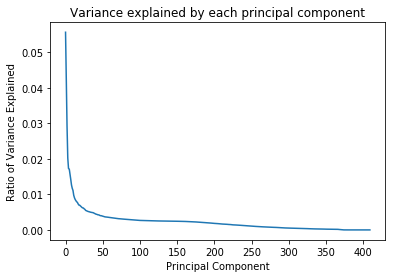

In [61]:
# Investigate the variance accounted for by each principal component.
plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each principal component")
plt.xlabel("Principal Component")
plt.ylabel("Ratio of Variance Explained")
plt.show()

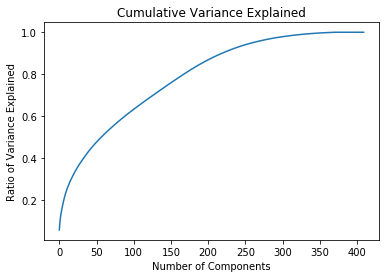

In [62]:
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of Variance Explained")
plt.show()

From the above plot we can can see that the first 200 principal components explain more that 80% of the variance. Hence, going forward I will be using the first 200 components.

In [63]:
# Re-apply PCA to the data by selecting first 200 components to retain.
pca_200 = PCA(n_components=200)
azdias_sample_pca = pca_200.fit_transform(azdias_sample_scaled)

#### 1.2.1 Interpret Principal Components

In [64]:
def get_pca_weights(pca, i):
    df_pca_components = pd.DataFrame(pca.components_, columns=list(azdias_sample_scaled.columns))
    weights = df_pca_components.iloc[i].sort_values(ascending=False)
    return weights

In [65]:
pca_weight_0 = get_pca_weights(pca_200, 0)
pca_weight_0

HH_EINKOMMEN_SCORE                0.150794
LP_STATUS_GROB_1.0                0.143744
PLZ8_ANTG3                        0.141806
PLZ8_BAUMAX                       0.138273
PLZ8_ANTG4                        0.137580
KBA13_HALTER_30                   0.113666
FINANZ_HAUSBAUER                  0.111365
EWDICHTE_6.0                      0.104439
ORTSGR_KLS9                       0.103173
KBA13_ALTERHALTER_30              0.098765
LP_STATUS_FEIN_1.0                0.098245
KBA13_HALTER_35                   0.093519
PLZ8_ANTG2                        0.087199
ANZ_HAUSHALTE_AKTIV               0.081451
RELAT_AB                          0.080111
KBA13_SEG_KOMPAKTKLASSE           0.077823
LP_STATUS_FEIN_2.0                0.077817
KBA13_KW_0_60                     0.077080
BALLRAUM_1.0                      0.075998
KBA13_BJ_2000                     0.074467
INNENSTADT_2.0                    0.074285
KBA13_HERST_ASIEN                 0.070635
CAMEO_DEUG_2015_9                 0.068316
KONSUMNAEHE

In [66]:
# and then print the linked values, sorted by weight.
pca_weight_1 = get_pca_weights(pca_200, 1)
print (pca_weight_1)

KBA13_HERST_BMW_BENZ           0.172023
KBA13_SEG_OBEREMITTELKLASSE    0.151299
KBA13_BMW                      0.146759
KBA13_MERCEDES                 0.144161
KBA13_SITZE_4                  0.140762
ORTSGR_KLS9                    0.137747
KBA13_SEG_SPORTWAGEN           0.133133
KBA13_SEG_OBERKLASSE           0.119848
KBA13_KMH_211                  0.114497
KBA05_HERST1                   0.113420
KBA13_KW_121                   0.112373
KBA13_KMH_250                  0.112260
KBA13_CCM_2501                 0.104988
KBA05_KW3                      0.103016
EWDICHTE_6.0                   0.100941
BALLRAUM_1.0                   0.100174
KBA13_CCM_3000                 0.098071
KBA13_KRSHERST_BMW_BENZ        0.093122
PLZ8_ANTG3                     0.092408
KBA13_HALTER_65                0.091184
KBA05_CCM4                     0.090841
KBA05_MOTOR                    0.090418
KONSUMNAEHE_1.0                0.090218
PLZ8_ANTG4                     0.089971
KBA05_MOD1                     0.088922


In [67]:
# and then print the linked values, sorted by weight.
pca_weight_2 = get_pca_weights(pca_200, 2)
print (pca_weight_2)

FINANZ_VORSORGER                0.205847
ALTERSKATEGORIE_GROB_4          0.184661
ZABEOTYP_3                      0.179142
SEMIO_ERL                       0.167410
SEMIO_LUST                      0.158406
RETOURTYP_BK_S                  0.142434
FINANZ_MINIMALIST               0.120630
CJT_GESAMTTYP_2.0               0.104282
W_KEIT_KIND_HH                  0.094203
FINANZTYP_2                     0.091893
FINANZTYP_5                     0.089562
SHOPPER_TYP_3.0                 0.089469
NATIONALITAET_KZ_1.0            0.080896
FINANZTYP_6                     0.070873
KBA05_ALTER4                    0.069670
KBA05_VORB0                     0.067677
CJT_GESAMTTYP_1.0               0.067614
KBA05_MAXAH                     0.063333
WOHNDAUER_2008                  0.061998
LP_STATUS_FEIN_1.0              0.060772
SEMIO_KRIT                      0.055324
HEALTH_TYP_2.0                  0.053060
FINANZ_HAUSBAUER                0.051245
GFK_URLAUBERTYP_4.0             0.048913
KBA13_HERST_ASIE

In [68]:
print("Top 10 positives for component 0")
pca_weight_0.head(10)

Top 10 positives for component 0


HH_EINKOMMEN_SCORE      0.150794
LP_STATUS_GROB_1.0      0.143744
PLZ8_ANTG3              0.141806
PLZ8_BAUMAX             0.138273
PLZ8_ANTG4              0.137580
KBA13_HALTER_30         0.113666
FINANZ_HAUSBAUER        0.111365
EWDICHTE_6.0            0.104439
ORTSGR_KLS9             0.103173
KBA13_ALTERHALTER_30    0.098765
Name: 0, dtype: float64

In [69]:
print("Top 10 negatives for component 0")
pca_weight_0.tail(10)


Top 10 negatives for component 0


GREEN_AVANTGARDE          -0.096766
KBA05_ANHANG              -0.100155
KBA13_SEG_GELAENDEWAGEN   -0.105817
PLZ8_GBZ                  -0.120426
FINANZ_MINIMALIST         -0.121853
KBA13_AUTOQUOTE           -0.126916
KBA05_AUTOQUOT            -0.133679
KBA05_GBZ                 -0.133748
PLZ8_ANTG1                -0.147583
MOBI_REGIO                -0.150565
Name: 0, dtype: float64

In [70]:
print("Top 10 positives for component 1")
pca_weight_1.head(10)

Top 10 positives for component 1


KBA13_HERST_BMW_BENZ           0.172023
KBA13_SEG_OBEREMITTELKLASSE    0.151299
KBA13_BMW                      0.146759
KBA13_MERCEDES                 0.144161
KBA13_SITZE_4                  0.140762
ORTSGR_KLS9                    0.137747
KBA13_SEG_SPORTWAGEN           0.133133
KBA13_SEG_OBERKLASSE           0.119848
KBA13_KMH_211                  0.114497
KBA05_HERST1                   0.113420
Name: 1, dtype: float64

In [71]:
print("Top 10 negatives for component 1")
pca_weight_1.tail(10)

Top 10 negatives for component 1


KBA13_HERST_FORD_OPEL   -0.104972
KBA13_HALTER_25         -0.105721
KBA13_AUTOQUOTE         -0.106657
KBA13_SEG_KLEINWAGEN    -0.116896
KBA13_HALTER_50         -0.121042
KBA13_KMH_140_210       -0.122144
KBA13_HALTER_55         -0.122649
KBA13_HALTER_20         -0.130724
KBA13_SITZE_5           -0.136530
KBA13_ALTERHALTER_60    -0.137811
Name: 1, dtype: float64

In [72]:
print("Top 10 positives for component 2")
pca_weight_2.head(10)

Top 10 positives for component 2


FINANZ_VORSORGER          0.205847
ALTERSKATEGORIE_GROB_4    0.184661
ZABEOTYP_3                0.179142
SEMIO_ERL                 0.167410
SEMIO_LUST                0.158406
RETOURTYP_BK_S            0.142434
FINANZ_MINIMALIST         0.120630
CJT_GESAMTTYP_2.0         0.104282
W_KEIT_KIND_HH            0.094203
FINANZTYP_2               0.091893
Name: 2, dtype: float64

In [73]:
print("Top 10 negatives for component 2")
pca_weight_2.tail(10)

Top 10 negatives for component 2


FINANZTYP_1                    -0.148924
SEMIO_KULT                     -0.154474
SEMIO_RAT                      -0.170201
FINANZ_ANLEGER                 -0.198809
SEMIO_TRADV                    -0.199459
FINANZ_UNAUFFAELLIGER          -0.206760
SEMIO_REL                      -0.210979
SEMIO_PFLICHT                  -0.212891
PRAEGENDE_JUGENDJAHRE_DECADE   -0.230107
FINANZ_SPARER                  -0.231108
Name: 2, dtype: float64

1. From component 0 we can see that **HH_EINKOMMEN_SCORE** and **MOBI_REGIO** are negatively co-related. This means that the moving pattern of the families is inversely proportional to the estimated net household income. 

2. From component 0 we can see that **PLZ8_ANTG3** and **PLZ8_ANTG4** have positive correlation which means that number of 6-10 family houses and number of 10+ family houses in the PLZ8 region increases together.

3. From component 1 we can see that **KBA13_SEG_SPORTWAGEN** and **KBA13_SEG_OBERKLASSE** are positively co-related which indicates that the people who have upper class cars also have sports cars.

4. From component 2 we can see that **ALTERSKATEGORIE_GROB** and **FINANZ_VORSORGER** have positive correlation. This means that as a person becomes older he/she is more prepared financially.

5. From component 2 we can see that **ALTERSKATEGORIE_GROB** and **PRAEGENDE_JUGENDJAHRE_DECADE** have negative correlation. This means that as PRAEGENDE_JUGENDJAHRE_DECADE increases the age decreases.

### 1.3 Apply K-Means clustering to the general population

In [74]:
def perform_kmeans(data, n_cluster):
    kmeans = KMeans(n_clusters = n_cluster)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [75]:
scores = []
number_of_clusters = list(range(1,26))
for k in number_of_clusters:
    print("Performing KMeans for k={}".format(k))
    scores.append(perform_kmeans(azdias_sample_pca, k))

Performing KMeans for k=1
Performing KMeans for k=2
Performing KMeans for k=3
Performing KMeans for k=4
Performing KMeans for k=5
Performing KMeans for k=6
Performing KMeans for k=7
Performing KMeans for k=8
Performing KMeans for k=9
Performing KMeans for k=10
Performing KMeans for k=11
Performing KMeans for k=12
Performing KMeans for k=13
Performing KMeans for k=14
Performing KMeans for k=15
Performing KMeans for k=16
Performing KMeans for k=17
Performing KMeans for k=18
Performing KMeans for k=19
Performing KMeans for k=20
Performing KMeans for k=21
Performing KMeans for k=22
Performing KMeans for k=23
Performing KMeans for k=24
Performing KMeans for k=25


Text(0,0.5,'SSE')

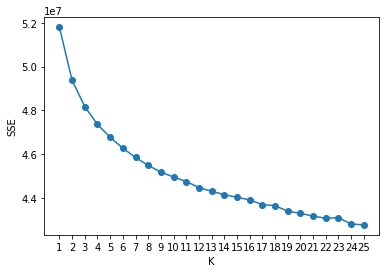

In [76]:
plt.plot(number_of_clusters, scores, linestyle='-', marker='o')
plt.xticks(number_of_clusters)
plt.xlabel('K')
plt.ylabel('SSE')

From the above plot it looks like 15 is the elbow point. Hence, we will be going forward with **k=15**.

In [75]:
# Re-fit the k-means model with 15 clusters and obtain cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=15)
model_15 = kmeans.fit(azdias_sample_pca)
azdias_sample_pred = model_15.predict(azdias_sample_pca)

### 1.4 Apply all the steps to the customer data

In [76]:
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [77]:
customers.shape

(191652, 369)

In [78]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [79]:
customers_clean = clean_data(customers)

Number of naturally missing values: 13864522
Converting unknown or missing values to NaN
Number of missing values after conversion: 18131486
Dropping outlier columns
Drop the columns from dataset which are not in feat_info
Dropping rows having > 7 missing values
Encoding Binary categorical columns


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


OneHot Encoding of multi-level categprical columns
Engineer mixed type features


In [80]:
customers_clean.shape

(131145, 410)

In [81]:
customers_clean_imputed = pd.DataFrame(fill_missing.transform(customers_clean))
customers_clean_imputed.columns = customers_clean.columns
customers_clean_imputed.index = customers_clean.index

In [82]:
customers_clean_scaled = scaler.transform(customers_clean_imputed)
customers_clean_scaled = pd.DataFrame(customers_clean_scaled, columns=list(customers_clean_imputed))

In [83]:
customers_pca = pca_200.transform(customers_clean_scaled)

In [84]:
customers_pred = model_15.predict(customers_pca)

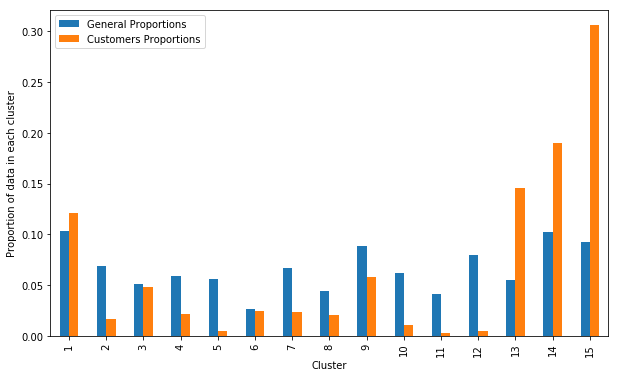

In [85]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

general_proportions = []
customers_proportions = []

for i in range(15):
    general_proportions.append((azdias_sample_pred == i).sum()/len(azdias_sample_pred))
    customers_proportions.append((customers_pred == i).sum()/len(customers_pred))

x = [i+1 for i in range(15)]
df_compare = pd.DataFrame({'Cluster' : x, 'General Proportions' : general_proportions, 'Customers Proportions':customers_proportions})

df_compare.plot(x='Cluster', y = ['General Proportions', 'Customers Proportions'], kind='bar', figsize=(10,6))
plt.ylabel('Proportion of data in each cluster')
plt.show()

In [86]:
# Characteristics of people who are overrepresented in customer data compared to the general population

overrepresented_customers_scaled = scaler.inverse_transform(pca_200.inverse_transform(customers_pca[np.where(customers_pred==14)]))
overrepresented_customers = pd.DataFrame(data=overrepresented_customers_scaled, 
                                         index=np.array(range(0, overrepresented_customers_scaled.shape[0])), 
                                         columns=customers_clean.columns)
overrepresented_customers.head(10)

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,...,WOHNLAGE_7.0,WOHNLAGE_8.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT
0,-2.578469,-0.104456,2.009398,0.008543,0.754217,2.494984,4.898281,0.837677,1.908760,5.135208,...,0.697599,-0.003868,0.456619,0.015463,0.739776,-0.073312,-0.026625,-0.111922,1.551247,1.102306
1,-2.738022,-0.024256,0.977228,-0.022008,1.432012,3.403972,4.306710,0.672440,2.391457,4.782381,...,0.086242,-0.014217,-0.028173,0.051751,1.023421,-0.036446,-0.003184,-0.007369,1.383570,1.094708
2,-1.162033,-0.028653,2.100140,0.000489,0.727535,2.600848,5.095562,0.581382,1.679768,5.461048,...,0.767682,-0.008514,1.034143,-0.072328,0.057753,0.019174,-0.065870,0.027128,1.626835,0.981538
3,-2.033107,-0.052641,1.148549,0.003494,0.495169,2.697981,5.104979,0.864577,2.049122,4.814118,...,0.396843,0.000660,0.980047,-0.083078,-0.012606,0.025637,0.039585,0.050416,2.025859,1.049179
4,4.934892,-0.064825,3.591449,0.005282,0.800644,2.140211,4.998660,1.212630,2.330379,4.874335,...,0.248237,-0.047797,1.055370,0.032611,-0.077922,-0.130612,-0.017027,0.137581,2.473454,1.048914
5,7.378094,0.015467,4.664878,-0.017163,3.113782,0.713704,4.231772,3.524467,4.756026,1.983555,...,0.228824,-0.019858,0.852485,0.120161,-0.068733,0.209075,-0.011317,-0.101671,4.693873,1.159166
6,-2.088529,-0.020557,3.605850,-0.005703,3.677546,0.682685,4.650854,2.296712,1.897072,3.828962,...,0.839439,0.046152,0.839232,0.029987,0.168991,-0.053998,0.023217,-0.007429,3.863697,1.035012
7,3.334829,0.031710,2.031175,0.013257,1.523257,2.276713,4.285501,1.162964,2.033832,5.116172,...,0.547948,-0.036623,0.282936,-0.034296,0.163818,0.623324,-0.157199,0.121417,1.997731,0.878153
8,3.236666,0.007056,0.921508,0.001783,0.348540,2.905931,5.290270,0.530336,1.761208,5.176238,...,0.700768,-0.045677,0.923593,-0.093900,0.222141,-0.089528,-0.047422,0.085117,1.326761,0.984505
9,-1.116651,-0.011317,2.710316,0.000360,0.763143,2.448012,4.874575,1.050531,2.575376,4.408295,...,0.077205,0.035008,0.340060,0.224236,0.516899,-0.294583,0.242218,-0.028830,1.970939,1.039972


In [87]:
# Characteristics of people who are underrepresented in customer data compared to the general population

underrepresented_customers_scaled = scaler.inverse_transform(pca_200.inverse_transform(customers_pca[np.where(customers_pred==11)]))
underrepresented_customers_scaled = pd.DataFrame(data=underrepresented_customers_scaled, 
                                         index=np.array(range(0, underrepresented_customers_scaled.shape[0])), 
                                         columns=customers_clean.columns)
underrepresented_customers_scaled.head(10)

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,...,WOHNLAGE_7.0,WOHNLAGE_8.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT
0,8.876887,-0.053553,3.241174,-0.006755,4.746305,3.900653,0.837899,4.936765,4.347854,2.041283,...,-0.008614,-0.037539,-0.218165,-0.009125,0.147220,0.814558,0.228714,0.036797,5.417810,0.229664
1,9.372921,-0.224518,0.104090,-0.002298,5.266616,5.388651,0.927875,4.659772,3.635898,2.813541,...,0.136349,0.019014,0.010128,-0.058400,-0.015813,0.093021,0.053885,0.917178,4.828954,0.646466
2,17.651955,-0.065592,0.835818,-0.006539,4.913183,4.732299,0.708934,4.512859,4.040448,2.568946,...,0.195666,-0.006618,-0.061517,0.049085,0.685873,-0.045535,0.237514,0.134579,4.776492,0.325737
3,7.659126,0.022840,0.859228,0.007080,4.234353,4.330092,1.379147,4.134115,3.122942,1.880317,...,-0.101412,0.045927,0.133331,0.041617,0.056702,-0.031879,0.850529,-0.050301,5.040872,-0.032522
4,14.962420,0.020527,2.214688,-0.009664,3.093326,3.867591,1.142501,3.951894,3.992483,2.706029,...,0.165019,-0.002194,-0.012502,0.005163,-0.332226,1.292436,0.120700,-0.073571,4.612997,-0.148242
5,7.628416,-0.049803,2.239063,-0.014942,4.364522,4.257001,0.688067,4.911939,4.124871,2.121131,...,0.049120,0.015569,0.025759,0.107882,0.134030,-0.040120,0.763444,0.009005,5.385085,0.100731
6,8.939977,-0.101260,1.060365,-0.001815,2.952736,3.834071,2.164104,2.674143,1.770069,3.595211,...,-0.027057,0.018580,0.093409,0.128192,-0.342288,0.147644,0.147254,0.825790,3.713730,-0.267182
7,3.121403,-0.173601,1.797699,-0.021687,3.563229,2.301773,3.187496,2.924414,2.066871,3.392353,...,0.169682,-0.018054,-0.126757,0.055893,0.096587,1.028071,-0.016763,-0.037031,4.107528,0.097660
8,16.262931,0.049022,1.058414,-0.007302,3.397545,3.436852,1.645954,3.461728,2.959996,3.376114,...,0.030387,-0.023030,-0.104977,0.042752,-0.049635,0.239543,0.102247,0.770070,4.600217,0.113082
9,5.771639,0.021047,0.972540,0.004850,2.951585,3.015418,1.566011,3.903653,3.952938,2.505909,...,-0.061285,-0.008585,0.263585,-0.045654,-0.110629,0.804998,0.070820,0.016880,4.578822,-0.003088


In [88]:
customers_cluster_specs = pd.DataFrame(scaler.inverse_transform(pca_200.inverse_transform(kmeans.cluster_centers_)), columns=customers_clean.columns)
customers_cluster_specs.index += 1
customers_cluster_specs

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,...,WOHNLAGE_7.0,WOHNLAGE_8.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT
1,8.963533,0.040809,1.372577,0.001599,1.810981,3.699838,3.199616,1.653998,1.883684,4.505777,...,0.103396,-0.000138,0.027827,0.000979,0.699525,0.136323,0.008842,0.126505,2.276229,0.146375
2,18.400899,0.064643,1.320762,0.002149,3.027791,3.961826,1.943301,3.614944,2.914446,2.845863,...,-0.003863,-0.001441,0.025374,0.005564,0.307849,0.283912,0.221758,0.155543,3.987622,0.115262
3,18.755265,0.244259,1.362895,0.015375,2.108297,3.808527,2.516684,2.751148,2.729235,3.471018,...,-0.005827,0.001733,0.055748,0.004081,0.397744,0.276457,0.100401,0.165569,3.357336,0.322529
4,1.887455,0.019103,1.935638,0.002889,3.443550,2.940779,3.751407,2.364020,1.848566,3.151441,...,0.731130,0.010411,0.188191,0.039105,0.344787,0.280803,0.069134,0.077980,3.158315,0.086668
5,11.945470,0.031512,1.536222,0.001511,3.536101,3.326936,2.048667,4.324215,3.848822,2.255677,...,0.053215,-0.000763,0.132131,-0.000302,0.027529,0.423230,0.348665,0.068748,4.656611,0.098867
6,2.176003,0.003125,2.090360,0.004421,3.277410,1.705477,3.713538,2.729535,2.834290,3.285599,...,0.002845,0.440869,0.186856,0.225193,0.196450,0.278409,0.059876,0.053217,3.662260,0.302585
7,1.740243,0.000909,2.747437,0.002535,3.956044,1.883972,3.201490,3.895815,4.188709,2.188938,...,0.288853,-0.005562,0.470671,0.116483,-0.015295,0.336306,0.077185,0.014650,4.771457,0.481816
8,15.771333,0.066443,1.461695,0.003933,2.357505,4.429676,2.898114,1.666143,1.064751,3.985792,...,0.100986,0.001069,0.000386,0.002996,0.760544,0.104042,0.012357,0.119676,2.168449,0.045226
9,13.287059,0.033287,1.475925,0.000853,1.956076,3.706382,2.918269,2.006131,1.711198,4.362473,...,-0.003502,-0.001842,0.013533,-0.002515,0.665530,0.129344,0.017035,0.177073,2.474407,0.044645
10,4.209983,0.004647,1.436907,0.001872,4.021972,3.217363,2.326791,3.562865,3.350541,2.803639,...,0.761849,0.008514,0.070343,0.001114,0.231969,0.407122,0.176201,0.113252,4.179529,0.062798


Cluster 15 is overrepresented in the Customer Data compared to Demographics Data. Some of the characteristics of this cluster are as follows:

1. We can also see that people in this cluster are not financial minimalist.

2. People of this cluster have high interest in making investments and saving money.

3. They have high interest in their own house.

Hence, this segment of the population should be relatively popular with the mail order company.

Cluster 12 is overrepresented in the Customer Data compared to Demographics Data. Some of the characteristics of this cluster are as follows:

1. We can also see that people in this cluster are financial minimalist.

2. People of this cluster have low interest in making investments and saving money.

3. They have low interest in their own house.

Hence, this segment of the population should be relatively unpopular with the mail order company.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [91]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [92]:
mailout_train.shape

(42962, 367)

In [93]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [94]:
# Get the number of responses for each type of response
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

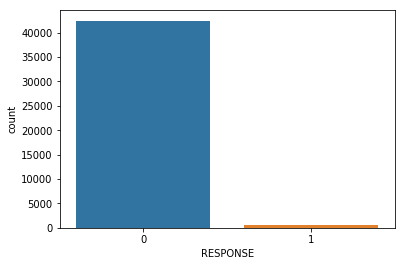

In [95]:
# Distribution for response type
sns.countplot(mailout_train['RESPONSE'])

In [96]:
mailout_train.shape

(42962, 367)

In [97]:
# Get the RESPONSE column to get the label dataframe
mailout_response = mailout_train['RESPONSE']

In [98]:
mailout_response.shape

(42962,)

In [99]:
print('Number of naturally missing values: {}'.format(mailout_train.isnull().sum().sum()))

Number of naturally missing values: 2217179


In [100]:
# Identify missing or unknown data values and convert them to NaNs.
for idx in feat_info_missing.index:
        column_name = feat_info_missing.iloc[idx]['Attribute']
        missing_or_unknown = feat_info_missing.iloc[idx]['missing_or_unknown']
        if column_name in mailout_train.columns:
            if isinstance(missing_or_unknown[0], str): 
                missing_or_unknown = [int(value) for value in feat_info_missing.iloc[idx]['missing_or_unknown'][0].split(',')]
            mailout_train[column_name] = mailout_train[column_name].replace(missing_or_unknown, np.nan)

In [101]:
# Find out number of missing data there is in each column of the training dataset.
mailout_missing_values_per_column = mailout_train.isnull().sum()
print(mailout_missing_values_per_column)

LNR                               0
AGER_TYP                      18890
AKT_DAT_KL                     6969
ALTER_HH                      13177
ALTER_KIND1                   40974
ALTER_KIND2                   42206
ALTER_KIND3                   42788
ALTER_KIND4                   42921
ALTERSKATEGORIE_FEIN           8155
ANZ_HAUSHALTE_AKTIV            7777
ANZ_HH_TITEL                   8246
ANZ_KINDER                     6969
ANZ_PERSONEN                   6969
ANZ_STATISTISCHE_HAUSHALTE     7777
ANZ_TITEL                      6969
ARBEIT                         7951
BALLRAUM                       7799
CAMEO_DEU_2015                 7888
CAMEO_DEUG_2015                7888
CAMEO_INTL_2015                7888
CJT_GESAMTTYP                   605
CJT_KATALOGNUTZER               605
CJT_TYP_1                       605
CJT_TYP_2                       605
CJT_TYP_3                       605
CJT_TYP_4                       605
CJT_TYP_5                       605
CJT_TYP_6                   

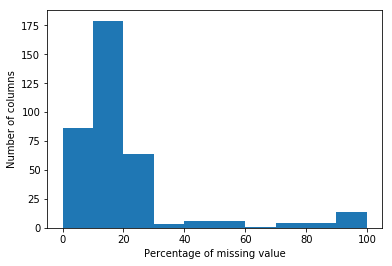

In [102]:
# Investigate pattern in the percentage of missing data in each column
plt.hist(mailout_missing_values_per_column/mailout_train.shape[0] * 100)
plt.xlabel('Percentage of missing value')
plt.ylabel('Number of columns')
plt.show()

From the above histogram we can see that most of the columns have <=30% missing values. Hence, I will be considering columns having >30% missing values as outlier columns.

In [103]:
# Finding the outlier columns from the dataset.
mailout_outlier_column_names = mailout_missing_values_per_column[mailout_missing_values_per_column/mailout_train.shape[0] > 0.3].index.tolist()
print(mailout_outlier_column_names)
print(len(mailout_outlier_column_names))

['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
38


In [104]:
def mailout_clean_data(df):
    
    feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
    del feat_info['Unnamed: 0']
    feat_info['Attribute'] = feat_info['Attribute'].fillna(method='ffill')
    
    attr_not_in_feat_info = np.setdiff1d(np.array(df.columns), np.array(feat_info.Attribute), assume_unique=True)

    
    feat_info_missing = feat_info[(feat_info["Meaning"].str.contains("unknown") | feat_info["Meaning"].str.contains("no "))]
    feat_info_missing = feat_info_missing['Value'].groupby([feat_info_missing.Attribute]).apply(list).reset_index()
    feat_info_missing.rename(columns={'Value': 'missing_or_unknown'}, inplace=True)
    
    print('Number of naturally missing values: {}'.format(df.isnull().sum().sum()))
    
    print('Converting unknown or missing values to NaN')
    for idx in feat_info_missing.index:
        column_name = feat_info_missing.iloc[idx]['Attribute']
        missing_or_unknown = feat_info_missing.iloc[idx]['missing_or_unknown']
        if column_name in df.columns:
            if isinstance(missing_or_unknown[0], str): 
                missing_or_unknown = [int(value) for value in feat_info_missing.iloc[idx]['missing_or_unknown'][0].split(',')]
            df[column_name] = df[column_name].replace(missing_or_unknown, np.nan)
    
    print('Number of missing values after conversion: {}'.format(df.isnull().sum().sum()))
    
    print('Dropping outlier columns')
    outlier_column_names = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 
                            'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 
                            'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_OFFLINE_DATUM', 
                            'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 
                            'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12', 
                            'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 
                            'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'EXTSEL992', 'KBA05_ANTG1', 
                            'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
    df.drop(outlier_column_names, axis=1, inplace=True)
    df.drop('LNR', axis=1, inplace=True)
    
    print('Drop the columns from dataset which are not in feat_info')
    columns_to_drop = set(attr_not_in_feat_info.tolist()) - set(outlier_column_names) - {'LNR', 'RESPONSE'}
    df.drop(list(columns_to_drop), axis=1, inplace=True)
    
    print('Encoding Binary categorical columns')
    df['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
    
    print('OneHot Encoding of multi-level categprical columns')
    multi_level_categorical_columns = ['ALTERSKATEGORIE_GROB', 'BALLRAUM', 'CAMEO_DEUG_2015', 
                                       'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'EWDICHTE', 'FINANZTYP', 
                                       'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP', 
                                       'HEALTH_TYP', 'INNENSTADT', 'KBA05_HERSTTEMP', 'KBA05_MODTEMP', 
                                       'KONSUMNAEHE', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 
                                       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 
                                       'WOHNLAGE', 'ZABEOTYP']
    df = pd.get_dummies(df, columns=multi_level_categorical_columns, prefix=multi_level_categorical_columns)
    
    print('Engineer mixed type features')
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(map_decade)
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(map_movement)
    df = df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)
    
    return df

In [105]:
# Clean mailout train dataset
mailout_clean = mailout_clean_data(mailout_train)

Number of naturally missing values: 3182014
Converting unknown or missing values to NaN
Number of missing values after conversion: 3182014
Dropping outlier columns
Drop the columns from dataset which are not in feat_info
Encoding Binary categorical columns
OneHot Encoding of multi-level categprical columns
Engineer mixed type features


In [106]:
mailout_clean.shape

(42962, 413)

In [107]:
# Drop RESPONSE columns to create the features dataframe
mailout_features = mailout_clean.drop(['RESPONSE'], axis=1)

In [108]:
# Get the RESPONSE column to get the label dataframe
mailout_response = mailout_clean['RESPONSE']

In [109]:

fill_missing = Imputer(strategy='median')
mailout_features_imputed = pd.DataFrame(fill_missing.fit_transform(mailout_features))
mailout_features_imputed.columns = mailout_features.columns
mailout_features_imputed.index = mailout_features.index

In [110]:
# Apply standard scaler to the imputed dataset
scaler = StandardScaler()
mailout_features_imputed_scaled = scaler.fit_transform(mailout_features_imputed)
mailout_features_imputed_scaled = pd.DataFrame(mailout_features_imputed_scaled, columns=mailout_features_imputed.columns)



In [111]:
mailout_features_imputed_scaled.shape

(42962, 412)

In [112]:
mailout_response.shape

(42962,)

In [113]:
import time
def fit_classifier(classifier, param_grid, X, y, scorer='roc_auc'):
    start = time.time()
    
    grid_obj = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring=scorer, cv=5)
    print("Classifier: {}".format(classifier.__class__.__name__))
    grid_obj.fit(X, y)
    end = time.time()
    
    time_taken = end-start
    print("Time taken in seconds : {}".format(time_taken))
    print("Best score : {}".format(grid_obj.best_score_))
    print("-"*100)
    
    return grid_obj.best_score_, grid_obj.best_estimator_, time_taken

In [114]:
# Initialize classifiers
logistic_regression = LogisticRegression(random_state=42) 
random_forest = RandomForestClassifier(random_state=42) 
ada_boost = AdaBoostClassifier(random_state=42)
gradient_boosting = GradientBoostingClassifier(random_state=42)

In [115]:
classifier_names = []
classifier_scores = []
classifier_best_estimators = []
classifiers_time_taken = []
classifiers = [logistic_regression, random_forest, ada_boost, gradient_boosting]

for classifier in classifiers:
    best_score, best_estimator, time_taken = fit_classifier(classifier, {}, mailout_features_imputed_scaled, 
                                                            mailout_response)
    classifier_names.append(classifier.__class__.__name__)
    classifier_scores.append(best_score)
    classifier_best_estimators.append(best_estimator)
    classifiers_time_taken.append(time_taken)

Classifier: LogisticRegression
Time taken in seconds : 195.1445095539093
Best score : 0.5843367744664455
----------------------------------------------------------------------------------------------------
Classifier: RandomForestClassifier
Time taken in seconds : 12.033421754837036
Best score : 0.48384133347778
----------------------------------------------------------------------------------------------------
Classifier: AdaBoostClassifier
Time taken in seconds : 89.1865701675415
Best score : 0.5788606432962725
----------------------------------------------------------------------------------------------------
Classifier: GradientBoostingClassifier
Time taken in seconds : 317.96957516670227
Best score : 0.5945723442335306
----------------------------------------------------------------------------------------------------


We can see here that the Gradient Boosting classfier produced the best score. I will be tuning this classifier using param grid in GridSearchCV to come up with the best estimator.

In [116]:
# Tune the best classifier(GradientBoostingClassifier) with the help of param grid in GridSearchCV

param_grid = {'loss': ['exponential'],
              'learning_rate': [0.01], 
              'n_estimators': [100],
              'max_depth': [6, 8]
             }

gradient_boosting = GradientBoostingClassifier(random_state=42)
gradient_boosting_best_score, gradient_boosting_best_est, time_taken = fit_classifier(gradient_boosting, param_grid, 
                                                                                      mailout_features_imputed_scaled, 
                                                                                      mailout_response)

Classifier: GradientBoostingClassifier
Time taken in seconds : 3691.3175506591797
Best score : 0.6151378596718878
----------------------------------------------------------------------------------------------------


In [117]:
gradient_boosting_best_est

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='exponential', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

To improve the performance of the GradientBoosting classifier model, I have tuned the hyperparameters using GridSearch to come up with the best estimator. After tuning, the training score improved from 0.5945 to 0.6151.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [118]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [119]:
mailout_test.shape

(42833, 366)

In [120]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [121]:
mailout_test_lnr = mailout_test['LNR']

In [122]:
mailout_test_clean = mailout_clean_data(mailout_test)

Number of naturally missing values: 2186757
Converting unknown or missing values to NaN
Number of missing values after conversion: 3146557
Dropping outlier columns
Drop the columns from dataset which are not in feat_info
Encoding Binary categorical columns
OneHot Encoding of multi-level categprical columns
Engineer mixed type features


In [123]:
mailout_test_clean_imputed = pd.DataFrame(fill_missing.transform(mailout_test_clean))
mailout_test_clean_imputed_scaled = pd.DataFrame(scaler.transform(mailout_test_clean_imputed), columns= list(mailout_test_clean.columns.values))

In [124]:
mailout_test_response = gradient_boosting_best_est.predict(mailout_test_clean_imputed_scaled)

In [125]:
mailout_test_response_proba = gradient_boosting_best_est.predict_proba(mailout_test_clean_imputed_scaled)
mailout_test_response_proba

array([[ 0.98854406,  0.01145594],
       [ 0.98388444,  0.01611556],
       [ 0.99660068,  0.00339932],
       ..., 
       [ 0.98681551,  0.01318449],
       [ 0.99654898,  0.00345102],
       [ 0.99694072,  0.00305928]])

In [126]:
kaggle_df = pd.DataFrame({'LNR': mailout_test_lnr, 'RESPONSE': mailout_test_response_proba[:, 1]})
kaggle_df.head()

,LNR,RESPONSE
0,1754,0.011456
1,1770,0.016116
2,1465,0.003399
3,1470,0.002849
4,1478,0.010670


In [127]:
kaggle_df.to_csv('kaggle_submission.csv', index=False)